In [29]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [30]:
SIZE = 4  # map size

env = gym.make('FrozenLake-v1', is_slippery=False)
print(env.desc)

def int2loc(x):
    """
    Convert state number into 2d matrix index
    e.g. 3 -> (0, 4),  4 -> (1, 0)
    """
    return (x // SIZE, x % SIZE)

assert int2loc(8) == (2,0)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


# SARSA

In [31]:
class SARSA():
    
    def __init__(self, shape=(SIZE, SIZE, 4), e=0.8, y=0.9, lr=1e-1,):
        
        self.e  = e
        self.y  = y
        self.lr = lr
        self.q = np.zeros(shape)
        
        self.test_mode = False
    
    def action(self, state):

        if not self.test_mode and np.random.rand() <= self.e:
            action = np.random.choice([0,1,2,3])
        else:
            action = np.argmax(self.q[state])
        return action
    
    def learn(self, state, action, state_, action_, reward, done):

        q_next = self.q[(*state_, action_)] if not done else 0.0
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        #print(td_error)
        self.q[(*state, action)] += self.lr * td_error

In [32]:
def episode(env, agent):
    
    state = int2loc(env.reset())
    action = agent.action(state)
    
    for _ in range(MAX_STEPS):
        
        # take action & observe
        state_, reward, done, _ = env.step(action)
        state_ = int2loc(state_)
        
        # choose next action
        action_ = agent.action(state_)
        
        # update q value
        agent.learn(state, action, state_, action_, reward, done);
        
        # iter to next step
        state = state_
        action = action_
        
        if done:
            return reward

In [33]:
EPISODES = 100000
MAX_STEPS = 100  # max steps before terminating an episode

agent = SARSA(e=1, lr=0.2)
returns = []

for i in range(EPISODES):
    
    episode(env, agent);
    
    if agent.e >= 0.2:
        agent.e *= 0.996
        
    if i % 200 == 199:
        agent.test_mode = True
        r = [episode(env, agent) for _ in range(10)]
        returns.append(sum(r) / len(r))
        agent.test_mode = False

In [34]:
agent.q

array([[[0.283, 0.297, 0.499, 0.293],
        [0.333, 0.   , 0.602, 0.297],
        [0.351, 0.698, 0.313, 0.367],
        [0.399, 0.   , 0.32 , 0.29 ]],

       [[0.339, 0.279, 0.   , 0.353],
        [0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.793, 0.   , 0.446],
        [0.   , 0.   , 0.   , 0.   ]],

       [[0.409, 0.   , 0.599, 0.425],
        [0.463, 0.756, 0.581, 0.   ],
        [0.624, 0.895, 0.   , 0.491],
        [0.   , 0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.772, 0.892, 0.565],
        [0.764, 0.877, 1.   , 0.731],
        [0.   , 0.   , 0.   , 0.   ]]])

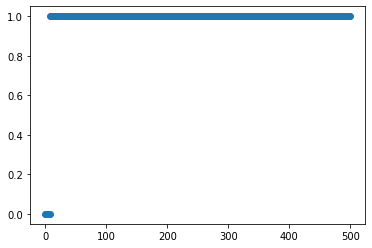

In [35]:
plt.scatter(range(len(returns)), returns);

In [36]:
def pretty(x : int):
    if   x == 0:
        return '←'
    elif x == 1:
        return '↓'
    elif x == 2:
        return '→'
    else:
        return '↑'
pretty = np.vectorize(pretty)

In [37]:
# visualize policy
# terminal states are marked with X

np.array([pretty(np.argmax(agent.q, axis=2)[i,j]) 
          if not np.all(agent.q[i,j]==0) else 'X' 
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['→', '→', '↓', '←'],
       ['↑', 'X', '↓', 'X'],
       ['→', '↓', '↓', 'X'],
       ['X', '→', '→', 'X']], dtype='<U1')

# Q-Learning

In [38]:
class QL(SARSA):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def learn(self, state, action, state_, action_, reward, done):
        q_next = np.max(self.q[state_]) if not done else 0.0         # <- difference
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        self.q[(*state, action)] += self.lr * td_error

In [39]:
EPISODES = 100000
MAX_STEPS = 100

agent = QL(e=1, lr=0.2)
returns = []

for i in range(EPISODES):
    
    episode(env, agent);
    
    if agent.e >= 0.2:
        agent.e *= 0.996
        
    if i % 200 == 199:
        agent.test_mode = True
        r = [episode(env, agent) for _ in range(10)]
        returns.append(sum(r) / len(r))
        agent.test_mode = False

In [40]:
agent.q

array([[[0.531, 0.59 , 0.59 , 0.531],
        [0.531, 0.   , 0.656, 0.59 ],
        [0.59 , 0.729, 0.59 , 0.656],
        [0.656, 0.   , 0.246, 0.427]],

       [[0.59 , 0.656, 0.   , 0.531],
        [0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.81 , 0.   , 0.656],
        [0.   , 0.   , 0.   , 0.   ]],

       [[0.656, 0.   , 0.729, 0.59 ],
        [0.656, 0.81 , 0.81 , 0.   ],
        [0.729, 0.9  , 0.   , 0.729],
        [0.   , 0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.81 , 0.9  , 0.729],
        [0.81 , 0.9  , 1.   , 0.81 ],
        [0.   , 0.   , 0.   , 0.   ]]])

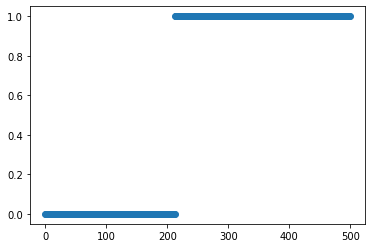

In [41]:
plt.scatter(range(len(returns)), returns);

In [42]:
np.array([pretty(np.argmax(agent.q, axis=2)[i,j]) 
          if not np.all(agent.q[i,j]==0) else 'X' 
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['↓', '→', '↓', '←'],
       ['↓', 'X', '↓', 'X'],
       ['→', '↓', '↓', 'X'],
       ['X', '→', '→', 'X']], dtype='<U1')